In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss, PULossWrapped, PURankingLoss
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load Data

In [2]:
DATA_DIR = os.path.join("data", "UCI HAR Dataset")

In [3]:
X_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "X_train.txt"),
    delim_whitespace=True,
    header=None
)
X_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "X_test.txt"),
    delim_whitespace=True,
    header=None
)

y_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "y_train.txt"),
    header=None
)[0]
y_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "y_test.txt"),
    header=None
)[0]

/tmp/ipykernel_4525/1776149928.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(
/tmp/ipykernel_4525/1776149928.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(


In [4]:
pd.set_option('display.max_columns', None)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,0.963396,-0.140840,0.115375,-0.985250,-0.981708,-0.877625,-0.985001,-0.984416,-0.894677,0.892055,-0.161265,0.124660,0.977436,-0.123213,0.056483,-0.375426,0.899469,-0.970905,-0.975510,-0.984325,-0.988849,-0.917743,-1.0,-1.0,0.113806,-0.590425,0.591146,-0.591773,0.592469,-0.745449,0.720862,-0.712372,0.711300,-0.995112,0.995675,-0.995668,0.991653,0.570222,0.439027,0.986913,0.077996,0.005001,-0.067831,-0.993519,-0.988360,-0.993575,-0.994488,-0.986207,-0.992818,-0.985180,-0.991994,-0.993119,0.989835,0.991957,0.990519,-0.993522,-0.999935,-0.999820,-0.999878,-0.994364,-0.986025,-0.989234,-0.819949,-0.793046,-0.888853,1.000000,-0.220747,0.636831,0.387644,0.241401,-0.052253,0.264177,0.373439,0.341778,-0.569791,0.265399,-0.477875,-0.385300,0.033644,-0.126511,-0.006101,-0.031365,0.107725,-0.985310,-0.976623,-0.992205,-0.984586,-0.976353,-0.992362,-0.867044,-0.933786,-0.747566,0.847308,0.914895,0.830841,-0.967184,-0.999578,-0.999354,-0.999763,-0.983438,-0.978614,-0.992966,0.082632,0.202268,-0.168757,0.096323,-0.274985,0.498644,-0.220317,1.000000,-0.972971,0.316655,0.375726,0.723399,-0.771112,0.690213,-0.331831,0.709584,0.134873,0.301099,-0.099167,-0.055517,-0.061986,-0.992111,-0.992519,-0.992055,-0.992165,-0.994942,-0.992619,-0.990156,-0.986743,-0.992042,0.994429,0.991756,0.989352,-0.994453,-0.999938,-0.999954,-0.999923,-0.992300,-0.996939,-0.992243,-0.589851,-0.688459,-0.572107,0.292376,-0.361998,0.405543,-0.039007,0.989284,-0.414560,0.391603,0.282251,0.927270,-0

In [5]:
activity_labels_df = pd.read_csv("data/UCI HAR Dataset/activity_labels.txt", sep='\s+', header=None, names=["id", "label"])
print(activity_labels_df)
labels = activity_labels_df["label"].to_list()

   id               label
0   1             WALKING
1   2    WALKING_UPSTAIRS
2   3  WALKING_DOWNSTAIRS
3   4             SITTING
4   5            STANDING
5   6              LAYING


In [6]:
y_train_np = y_train.to_numpy() - 1
y_test_np = y_test.to_numpy() - 1

In [7]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()


In [8]:
X_tr_tensor   = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_tr_tensor   = torch.tensor(y_train.values, dtype=torch.long) - 1
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long) - 1


In [9]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [10]:
batch_size = 64

tr_dataset   = TensorDataset(X_tr_tensor, y_tr_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True) # train 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

## PU-learnining 

### Transfirm Data to PU Problem

In [225]:
positive_class = 2
#pos_unmark_ratio = 0.5

y_train_pu = np.where(y_train_np == positive_class, 1, -1)
y_test_pu = np.where(y_test_np == positive_class, 1, -1)
print(f"Positives before reduction, train: {y_train_pu[y_train_pu == 1].sum()}")
print(f"Positives before reduction, test: {y_test_pu[y_test_pu == 1].sum()}")


pos_idx_tr = np.where(y_train_pu == 1)[0]
pos_idx_tst = np.where(y_test_pu == 1)[0]
np.random.seed(0)
unmark_pos_tr = np.random.choice(pos_idx_tr, size=len(pos_idx_tr)//3, replace=False)
y_train_pu[unmark_pos_tr] = -1
unmark_pos_tst = np.random.choice(pos_idx_tst, size=len(pos_idx_tst)//3, replace=False)
y_test_pu[unmark_pos_tst] = -1
print(f"Positives after reduction, train: {y_train_pu[y_train_pu == 1].sum()}")
print(f"Positives after reduction, test: {y_test_pu[y_test_pu == 1].sum()}")


Positives before reduction, train: 986
Positives before reduction, test: 420
Positives after reduction, train: 658
Positives after reduction, test: 280


In [226]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [227]:
batch_size = 64

In [228]:
y_tr_tensor_pu   = torch.tensor(y_train_pu, dtype=torch.long)
y_test_tensor_pu = torch.tensor(y_test_pu, dtype=torch.long)

tr_dataset_pu   = TensorDataset(X_tr_tensor, y_tr_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader_pu = DataLoader(tr_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)


In [229]:
# positive_prior = np.where(y_train_np == positive_class, 1, 0).mean()
# positive_prior

positive_prior = torch.tensor(
    np.where(y_train_np == positive_class, 1, 0).mean(),
    dtype=torch.float32
)
# positive_prior = torch.tensor((y_train_pu).mean(),
#                               dtype=torch.float32)

positive_prior = torch.tensor(
    np.where(y_train_pu == 1, 1, 0).mean(),
    dtype=torch.float32
)
positive_prior

tensor(0.0895)

## CNN

In [111]:
in_channel = X_tr_tensor.shape[1]
seq_length = X_tr_tensor.shape[2]
n_output = len(y_tr_tensor_pu.unique())-1
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 561, n_output: 1


In [112]:
from baseline import Conv_Net, train, LSTMNet
model = Conv_Net(in_channel, seq_length, n_hidden, n_output)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [62]:
from pu_loss import PULoss
criterion = PULoss(prior=positive_prior)
#criterion = PULossWrapped(prior=positive_prior)
# criterion = nnPULoss(prior=positive_prior, nnPU=True)


## uPU Loss

In [19]:
model = train(model, criterion, train_loader_pu, test_loader_pu, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]/home/bebra/aic/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:01<00:00, 85.05it/s] 


Epoch [1/15], tr_loss: 0.16824 tr_acc: 0.90792 test_loss: 0.12123, test_acc: 0.90499


100%|██████████| 115/115 [00:00<00:00, 125.46it/s]


Epoch [2/15], tr_loss: 0.11018 tr_acc: 0.91050 test_loss: 0.10131, test_acc: 0.90499


100%|██████████| 115/115 [00:00<00:00, 136.81it/s]


Epoch [3/15], tr_loss: 0.09534 tr_acc: 0.91050 test_loss: 0.09198, test_acc: 0.90499


100%|██████████| 115/115 [00:00<00:00, 121.58it/s]


Epoch [4/15], tr_loss: 0.08534 tr_acc: 0.91050 test_loss: 0.08537, test_acc: 0.90499


100%|██████████| 115/115 [00:00<00:00, 154.71it/s]


Epoch [5/15], tr_loss: 0.07844 tr_acc: 0.91050 test_loss: 0.08051, test_acc: 0.90499


100%|██████████| 115/115 [00:00<00:00, 155.05it/s]


Epoch [6/15], tr_loss: 0.07393 tr_acc: 0.91050 test_loss: 0.07525, test_acc: 0.90499


100%|██████████| 115/115 [00:00<00:00, 142.17it/s]


Epoch [7/15], tr_loss: 0.06882 tr_acc: 0.91050 test_loss: 0.07202, test_acc: 0.90499


100%|██████████| 115/115 [00:00<00:00, 138.81it/s]


Epoch [8/15], tr_loss: 0.06417 tr_acc: 0.93648 test_loss: 0.06960, test_acc: 0.93213


100%|██████████| 115/115 [00:00<00:00, 147.12it/s]


Epoch [9/15], tr_loss: 0.06409 tr_acc: 0.93934 test_loss: 0.06751, test_acc: 0.93247


100%|██████████| 115/115 [00:00<00:00, 167.82it/s]


Epoch [10/15], tr_loss: 0.05935 tr_acc: 0.94083 test_loss: 0.06607, test_acc: 0.93281


100%|██████████| 115/115 [00:00<00:00, 137.82it/s]


Epoch [11/15], tr_loss: 0.05694 tr_acc: 0.94396 test_loss: 0.06495, test_acc: 0.93315


100%|██████████| 115/115 [00:00<00:00, 158.02it/s]


Epoch [12/15], tr_loss: 0.05522 tr_acc: 0.94478 test_loss: 0.06370, test_acc: 0.93349


100%|██████████| 115/115 [00:00<00:00, 156.77it/s]


Epoch [13/15], tr_loss: 0.05472 tr_acc: 0.94464 test_loss: 0.06280, test_acc: 0.93655


100%|██████████| 115/115 [00:00<00:00, 166.27it/s]


Epoch [14/15], tr_loss: 0.05267 tr_acc: 0.94627 test_loss: 0.06179, test_acc: 0.93553


100%|██████████| 115/115 [00:00<00:00, 177.41it/s]


Epoch [15/15], tr_loss: 0.03694 tr_acc: 0.94899 test_loss: 0.04837, test_acc: 0.93994


In [37]:
model.eval()
y_train_pu = np.where(y_train_np == positive_class, 1, -1)
out_train = model(X_tr_tensor.to(device)).cpu()
preds_train = torch.where(
            out_train > 0,
            torch.tensor(1, device=out_train.device),
            torch.tensor(-1, device=out_train.device)
        ).view(-1)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

          -1     0.9847    0.9998    0.9922      6366
           1     0.9989    0.8996    0.9466       986

    accuracy                         0.9864      7352
   macro avg     0.9918    0.9497    0.9694      7352
weighted avg     0.9866    0.9864    0.9861      7352

[[6365    1]
 [  99  887]]


In [ ]:
model.eval()
out_test = model(X_test_tensor.to(device))
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9727    0.9606    0.9666      2667
           1     0.6645    0.7429    0.7015       280

    accuracy                         0.9399      2947
   macro avg     0.8186    0.8517    0.8341      2947
weighted avg     0.9434    0.9399    0.9414      2947

[[2562  105]
 [  72  208]]


In [ ]:
model.eval()
y_test_pu = np.where(y_test_np == positive_class, 1, -1)
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9575    0.9980    0.9773      2527
           1     0.9840    0.7333    0.8404       420

    accuracy                         0.9603      2947
   macro avg     0.9708    0.8657    0.9089      2947
weighted avg     0.9613    0.9603    0.9578      2947

[[2522    5]
 [ 112  308]]


In [54]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train_pu[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(preds_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test_pu[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(preds_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:888
Total number of unmarked positive sampels: 328
Number of unmarked samples correctly predicted as positive: 295
In percentage: 0.8994
Test
Total number of positive sampels:313
Total number of unmarked positive sampels: 140
Number of unmarked samples correctly predicted as positive: 100
In percentage: 0.7143


In [67]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train_pu[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(preds_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test_pu[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(preds_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:758
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 371
In percentage: 0.7525
Test
Total number of positive sampels:250
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 119
In percentage: 0.5667


In [68]:
torch.save(model.state_dict, "models/pu_cnn_test2-1.pth")

## nnPU loss

In [113]:
criterion = PULoss(prior=positive_prior, nnPU=True)

In [115]:
num_epochs = 15
lr = 0.0001

In [116]:
model = Conv_Net(in_channel, seq_length, n_hidden, n_output)
model = model.to(device)
model = train(model, criterion, train_loader_pu, test_loader_pu, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]/home/bebra/aic/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:01<00:00, 78.47it/s]


Epoch [1/15], tr_loss: 0.17128 tr_acc: 0.90343 test_loss: 0.11951, test_acc: 0.90499


100%|██████████| 115/115 [00:01<00:00, 97.77it/s]


Epoch [2/15], tr_loss: 0.11321 tr_acc: 0.91689 test_loss: 0.10620, test_acc: 0.90974


100%|██████████| 115/115 [00:01<00:00, 88.34it/s]


Epoch [3/15], tr_loss: 0.09971 tr_acc: 0.92492 test_loss: 0.09337, test_acc: 0.91279


100%|██████████| 115/115 [00:01<00:00, 90.31it/s]


Epoch [4/15], tr_loss: 0.08284 tr_acc: 0.92750 test_loss: 0.08773, test_acc: 0.91415


100%|██████████| 115/115 [00:01<00:00, 84.28it/s]


Epoch [5/15], tr_loss: 0.07583 tr_acc: 0.92859 test_loss: 0.08477, test_acc: 0.91483


100%|██████████| 115/115 [00:01<00:00, 97.62it/s]


Epoch [6/15], tr_loss: 0.07019 tr_acc: 0.92982 test_loss: 0.07891, test_acc: 0.92162


100%|██████████| 115/115 [00:01<00:00, 94.18it/s]


Epoch [7/15], tr_loss: 0.05775 tr_acc: 0.93172 test_loss: 0.07623, test_acc: 0.91720


100%|██████████| 115/115 [00:01<00:00, 97.00it/s]


Epoch [8/15], tr_loss: 0.05417 tr_acc: 0.92995 test_loss: 0.07412, test_acc: 0.91958


100%|██████████| 115/115 [00:01<00:00, 91.30it/s]


Epoch [9/15], tr_loss: 0.05391 tr_acc: 0.93498 test_loss: 0.07313, test_acc: 0.91822


100%|██████████| 115/115 [00:01<00:00, 95.61it/s]


Epoch [10/15], tr_loss: 0.05354 tr_acc: 0.93430 test_loss: 0.07214, test_acc: 0.92094


100%|██████████| 115/115 [00:01<00:00, 90.07it/s]


Epoch [11/15], tr_loss: 0.05020 tr_acc: 0.93607 test_loss: 0.06100, test_acc: 0.92467


100%|██████████| 115/115 [00:01<00:00, 84.62it/s]


Epoch [12/15], tr_loss: 0.05185 tr_acc: 0.93716 test_loss: 0.05915, test_acc: 0.92738


100%|██████████| 115/115 [00:01<00:00, 90.13it/s]


Epoch [13/15], tr_loss: 0.05342 tr_acc: 0.93811 test_loss: 0.06088, test_acc: 0.92908


100%|██████████| 115/115 [00:01<00:00, 91.57it/s]


Epoch [14/15], tr_loss: 0.04927 tr_acc: 0.93743 test_loss: 0.05717, test_acc: 0.92229


100%|██████████| 115/115 [00:01<00:00, 95.74it/s]


Epoch [15/15], tr_loss: 0.04632 tr_acc: 0.93580 test_loss: 0.05698, test_acc: 0.92433


In [117]:
model.eval()
y_train_pu = np.where(y_train_np == positive_class, 1, -1)
out_train = model(X_tr_tensor.to(device)).cpu()
preds_train = torch.where(
            out_train > 0,
            torch.tensor(1, device=out_train.device),
            torch.tensor(-1, device=out_train.device)
        ).view(-1)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

          -1     0.9494    1.0000    0.9741      6366
           1     1.0000    0.6562    0.7924       986

    accuracy                         0.9539      7352
   macro avg     0.9747    0.8281    0.8832      7352
weighted avg     0.9562    0.9539    0.9497      7352

[[6366    0]
 [ 339  647]]


In [118]:
model.eval()
out_test = model(X_test_tensor.to(device))
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9377    0.9816    0.9592      2667
           1     0.6839    0.3786    0.4874       280

    accuracy                         0.9243      2947
   macro avg     0.8108    0.6801    0.7233      2947
weighted avg     0.9136    0.9243    0.9143      2947

[[2618   49]
 [ 174  106]]


In [119]:
model.eval()
y_test_pu = np.where(y_test_np == positive_class, 1, -1)
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9051    1.0000    0.9502      2527
           1     1.0000    0.3690    0.5391       420

    accuracy                         0.9101      2947
   macro avg     0.9525    0.6845    0.7447      2947
weighted avg     0.9186    0.9101    0.8916      2947

[[2527    0]
 [ 265  155]]


In [122]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train_pu[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train_pu==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test_pu[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test_pu==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:658
Total number of unmarked positive sampels: 328
Number of unmarked samples correctly predicted as positive: 124
In percentage: 0.3780
Test
Total number of positive sampels:280
Total number of unmarked positive sampels: 140
Number of unmarked samples correctly predicted as positive: 91
In percentage: 0.6500


## LSTM with uPU

In [207]:
from baseline import LSTMNet, train
model_lstm = LSTMNet(in_channel, hidden_dim=128, n_output=1, num_layers=1)
model_lstm.to(device)

LSTMNet(
  (lstm): LSTM(1, 128, batch_first=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [208]:
from pu_loss import PULoss
criterion = PULoss(prior=positive_prior, nnPU=True)
model_lstm = train(model_lstm, criterion, train_loader_pu, test_loader_pu, 0.002, 15, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:02<00:00, 51.33it/s]


Epoch [1/15], tr_loss: 0.23472 tr_acc: 0.90683 test_loss: 0.33297, test_acc: 0.90499


100%|██████████| 115/115 [00:01<00:00, 58.88it/s]


Epoch [2/15], tr_loss: 0.16286 tr_acc: 0.91050 test_loss: 0.20964, test_acc: 0.90024


100%|██████████| 115/115 [00:01<00:00, 60.04it/s]


Epoch [3/15], tr_loss: 0.13186 tr_acc: 0.91036 test_loss: 0.24198, test_acc: 0.88293


100%|██████████| 115/115 [00:01<00:00, 59.48it/s]


Epoch [4/15], tr_loss: 0.12807 tr_acc: 0.91132 test_loss: 0.33423, test_acc: 0.85171


100%|██████████| 115/115 [00:01<00:00, 59.45it/s]


Epoch [5/15], tr_loss: 0.12205 tr_acc: 0.91200 test_loss: 0.16628, test_acc: 0.89481


100%|██████████| 115/115 [00:01<00:00, 58.98it/s]


Epoch [6/15], tr_loss: 0.11688 tr_acc: 0.90873 test_loss: 0.15378, test_acc: 0.90397


100%|██████████| 115/115 [00:01<00:00, 59.21it/s]


Epoch [7/15], tr_loss: 0.10526 tr_acc: 0.91091 test_loss: 1.26965, test_acc: 0.90499


100%|██████████| 115/115 [00:01<00:00, 58.82it/s]


Epoch [8/15], tr_loss: 0.12682 tr_acc: 0.91390 test_loss: 0.27435, test_acc: 0.86291


100%|██████████| 115/115 [00:01<00:00, 58.65it/s]


Epoch [9/15], tr_loss: 0.10736 tr_acc: 0.91227 test_loss: 0.13828, test_acc: 0.90567


100%|██████████| 115/115 [00:01<00:00, 58.85it/s]


Epoch [10/15], tr_loss: 0.09720 tr_acc: 0.91336 test_loss: 0.15099, test_acc: 0.90668


100%|██████████| 115/115 [00:01<00:00, 59.46it/s]


Epoch [11/15], tr_loss: 0.09411 tr_acc: 0.91798 test_loss: 0.15553, test_acc: 0.90363


100%|██████████| 115/115 [00:01<00:00, 59.09it/s]


Epoch [12/15], tr_loss: 0.09586 tr_acc: 0.91744 test_loss: 0.17928, test_acc: 0.90533


100%|██████████| 115/115 [00:01<00:00, 59.27it/s]


Epoch [13/15], tr_loss: 0.09095 tr_acc: 0.91649 test_loss: 0.17724, test_acc: 0.90465


100%|██████████| 115/115 [00:01<00:00, 59.33it/s]


Epoch [14/15], tr_loss: 0.09031 tr_acc: 0.91961 test_loss: 0.18064, test_acc: 0.90363


100%|██████████| 115/115 [00:01<00:00, 59.60it/s]


Epoch [15/15], tr_loss: 0.09027 tr_acc: 0.91703 test_loss: 0.15886, test_acc: 0.90363


In [209]:
X_test_tensor = X_test_tensor.permute(0, 2, 1)

In [210]:
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_test = []
model_lstm.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_lstm(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        preds_test.append(preds.cpu())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))


              precision    recall  f1-score   support

          -1     0.9074    0.9951    0.9492      2667
           1     0.4091    0.0321    0.0596       280

    accuracy                         0.9036      2947
   macro avg     0.6582    0.5136    0.5044      2947
weighted avg     0.8600    0.9036    0.8647      2947

[[2654   13]
 [ 271    9]]


In [211]:
y_test_pu = np.where(y_test_np == positive_class, 1, -1)
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_test = []
model_lstm.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_lstm(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        preds_test.append(preds.cpu())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))


              precision    recall  f1-score   support

          -1     0.8619    0.9976    0.9248      2527
           1     0.7273    0.0381    0.0724       420

    accuracy                         0.8609      2947
   macro avg     0.7946    0.5179    0.4986      2947
weighted avg     0.8427    0.8609    0.8033      2947

[[2521    6]
 [ 404   16]]


In [212]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train_pu[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train_pu==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test_pu[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test_pu==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:658
Total number of unmarked positive sampels: 328
Number of unmarked samples correctly predicted as positive: 124
In percentage: 0.3780
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 140
Number of unmarked samples correctly predicted as positive: 7
In percentage: 0.0500


## Mamba

In [218]:
from baseline import MambaClassifier, train, PULoss

criterion = PULoss(positive_prior, nnPU=False)
model_mamba = MambaClassifier(in_channel, hidden_dim=128, num_classes=1, num_layers=1, dropout=0.5)
model_mamba = model_mamba.to(device)
print(model_mamba)

MambaClassifier(
  (input_proj): Linear(in_features=1, out_features=128, bias=True)
  (blocks): Sequential(
    (0): MambaBlock(
      (mamba): Mamba(
        (in_proj): Linear(in_features=128, out_features=512, bias=False)
        (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
        (act): SiLU()
        (x_proj): Linear(in_features=256, out_features=40, bias=False)
        (dt_proj): Linear(in_features=8, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=128, bias=False)
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [219]:
model_mamba = train(model_mamba, criterion, train_loader_pu, test_loader_pu, 0.001, 20, device)

  0%|          | 0/115 [00:00<?, ?it/s]/home/bebra/aic/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:06<00:00, 18.10it/s]


Epoch [1/20], tr_loss: 0.17718 tr_acc: 0.91104 test_loss: 0.14674, test_acc: 0.90329


100%|██████████| 115/115 [00:06<00:00, 19.15it/s]


Epoch [2/20], tr_loss: 0.16056 tr_acc: 0.91036 test_loss: 0.15775, test_acc: 0.90431


100%|██████████| 115/115 [00:06<00:00, 19.07it/s]


Epoch [3/20], tr_loss: 0.15452 tr_acc: 0.90968 test_loss: 0.15656, test_acc: 0.90363


100%|██████████| 115/115 [00:06<00:00, 18.95it/s]


Epoch [4/20], tr_loss: 0.14883 tr_acc: 0.90914 test_loss: 0.14139, test_acc: 0.90261


100%|██████████| 115/115 [00:06<00:00, 18.92it/s]


Epoch [5/20], tr_loss: 0.13947 tr_acc: 0.91050 test_loss: 0.14738, test_acc: 0.90363


100%|██████████| 115/115 [00:06<00:00, 18.81it/s]


Epoch [6/20], tr_loss: 0.13237 tr_acc: 0.91227 test_loss: 0.14360, test_acc: 0.90567


100%|██████████| 115/115 [00:06<00:00, 18.72it/s]


Epoch [7/20], tr_loss: 0.12766 tr_acc: 0.91417 test_loss: 0.13752, test_acc: 0.90635


100%|██████████| 115/115 [00:06<00:00, 18.64it/s]


Epoch [8/20], tr_loss: 0.12500 tr_acc: 0.91553 test_loss: 0.13466, test_acc: 0.90906


100%|██████████| 115/115 [00:06<00:00, 18.65it/s]


Epoch [9/20], tr_loss: 0.12203 tr_acc: 0.91839 test_loss: 0.13345, test_acc: 0.90906


100%|██████████| 115/115 [00:06<00:00, 18.59it/s]


Epoch [10/20], tr_loss: 0.12015 tr_acc: 0.91880 test_loss: 0.13262, test_acc: 0.91110


100%|██████████| 115/115 [00:06<00:00, 18.64it/s]


Epoch [11/20], tr_loss: 0.11894 tr_acc: 0.91934 test_loss: 0.13293, test_acc: 0.90906


100%|██████████| 115/115 [00:06<00:00, 18.54it/s]


Epoch [12/20], tr_loss: 0.11384 tr_acc: 0.92002 test_loss: 0.13099, test_acc: 0.91008


100%|██████████| 115/115 [00:06<00:00, 18.42it/s]


Epoch [13/20], tr_loss: 0.10992 tr_acc: 0.92193 test_loss: 0.12883, test_acc: 0.91279


100%|██████████| 115/115 [00:06<00:00, 18.37it/s]


Epoch [14/20], tr_loss: 0.10554 tr_acc: 0.92356 test_loss: 0.12787, test_acc: 0.91619


100%|██████████| 115/115 [00:06<00:00, 18.39it/s]


Epoch [15/20], tr_loss: 0.10858 tr_acc: 0.91608 test_loss: 0.11627, test_acc: 0.91822


100%|██████████| 115/115 [00:06<00:00, 18.30it/s]


Epoch [16/20], tr_loss: 0.10312 tr_acc: 0.92206 test_loss: 0.12754, test_acc: 0.91754


100%|██████████| 115/115 [00:06<00:00, 18.20it/s]


Epoch [17/20], tr_loss: 0.10249 tr_acc: 0.92315 test_loss: 0.13268, test_acc: 0.91551


100%|██████████| 115/115 [00:06<00:00, 18.26it/s]


Epoch [18/20], tr_loss: 0.10291 tr_acc: 0.92002 test_loss: 0.12996, test_acc: 0.91619


100%|██████████| 115/115 [00:06<00:00, 18.23it/s]


Epoch [19/20], tr_loss: 0.10046 tr_acc: 0.92220 test_loss: 0.12383, test_acc: 0.92060


100%|██████████| 115/115 [00:06<00:00, 18.25it/s]


Epoch [20/20], tr_loss: 0.09192 tr_acc: 0.92546 test_loss: 0.11580, test_acc: 0.92569


In [220]:
X_test_tensor = X_test_tensor.permute(0, 2, 1)

In [221]:
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        preds_test.append(preds.cpu())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))


              precision    recall  f1-score   support

          -1     0.9540    0.9644    0.9592      2667
           1     0.6215    0.5571    0.5876       280

    accuracy                         0.9257      2947
   macro avg     0.7878    0.7608    0.7734      2947
weighted avg     0.9224    0.9257    0.9239      2947

[[2572   95]
 [ 124  156]]


In [222]:
y_test_pu = np.where(y_test_np == positive_class, 1, -1)
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        preds_test.append(preds.cpu())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))


              precision    recall  f1-score   support

          -1     0.9292    0.9913    0.9592      2527
           1     0.9124    0.5452    0.6826       420

    accuracy                         0.9277      2947
   macro avg     0.9208    0.7683    0.8209      2947
weighted avg     0.9268    0.9277    0.9198      2947

[[2505   22]
 [ 191  229]]


In [223]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train_pu[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train_pu==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test_pu[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test_pu==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:658
Total number of unmarked positive sampels: 328
Number of unmarked samples correctly predicted as positive: 124
In percentage: 0.3780
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 140
Number of unmarked samples correctly predicted as positive: 73
In percentage: 0.5214


In [224]:
torch.save(model_mamba.state_dict, "models/pu_mambe_test1.pth")

## InceptionTime

In [230]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped

criterion = PULossWrapped(prior=positive_prior, nnPU=True)

X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test_pu])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph())


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.402403,0.560033,0.239748,0.897523,00:09
1,0.156637,0.898163,0.371212,0.789617,00:09
2,0.095236,0.928728,0.096618,0.930098,00:09
3,0.082605,0.928591,0.572673,0.543604,00:09
4,0.062600,0.937774,0.260104,0.761792,00:09
5,0.060210,0.937774,0.077815,0.938242,00:09
6,0.054909,0.939693,0.141203,0.898202,00:09
7,0.051812,0.945587,0.178568,0.937224,00:09
8,0.055390,0.948876,0.070853,0.945707,00:09
9,0.047694,0.951069,0.072385,0.945029,00:09


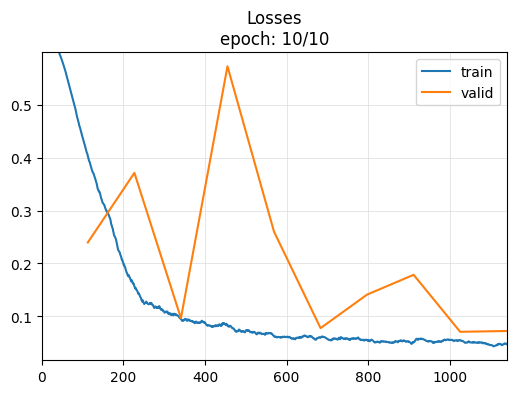

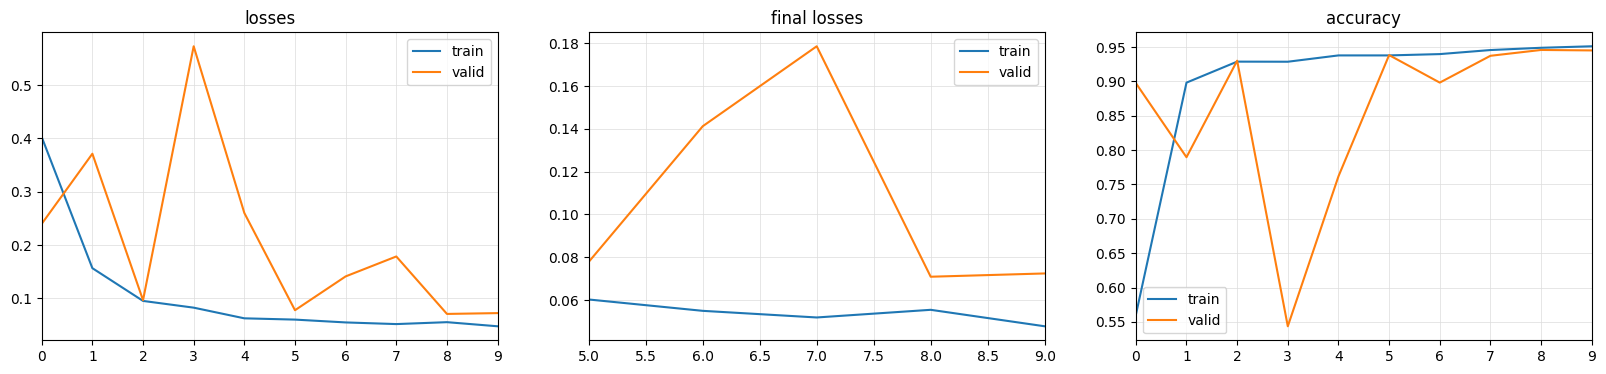

In [231]:
clf.fit_one_cycle(10, 1e-4)

In [232]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(10299, 1, 561)

In [ ]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

In [235]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds = probas.argmax(dim=-1)
print(classification_report(target, preds, digits=4))
print(confusion_matrix(target, preds))

              precision    recall  f1-score   support

           0     0.9838    0.9550    0.9692      2667
           1     0.6648    0.8500    0.7461       280

    accuracy                         0.9450      2947
   macro avg     0.8243    0.9025    0.8576      2947
weighted avg     0.9535    0.9450    0.9480      2947

[[2547  120]
 [  42  238]]


In [236]:
y_test_pu = np.where(y_test_np == positive_class, 1, 0)

In [239]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test_pu, preds, digits=4))
print(confusion_matrix(y_test_pu, preds))

              precision    recall  f1-score   support

           0     0.9730    0.9968    0.9848      2527
           1     0.9777    0.8333    0.8997       420

    accuracy                         0.9735      2947
   macro avg     0.9753    0.9151    0.9422      2947
weighted avg     0.9736    0.9735    0.9726      2947

[[2519    8]
 [  70  350]]


In [240]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
# print("Train")
# correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train_pu[unmark_pos_tr]).sum()
# print(f"Total number of positive sampels:{(y_train_pu==1).sum()}\n\
# Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
# Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
# In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test_pu[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test_pu==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 140
Number of unmarked samples correctly predicted as positive: 112
In percentage: 0.8000
